# This notebook contains the code to train SynthMorph with 3D sinograms

## 1. Import of all the libraries and packages needed to run the code

In [1]:
import tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import neurite as ne
import voxelmorph as vxm
import odl
from tensorflow.keras.layers import Dense

2023-08-22 14:05:12.227100: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-22 14:05:12.696024: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mamo/devel/build/INSTALL/lib:/home/mamo/devel/build/INSTALL/lib64::
2023-08-22 14:05:12.696060: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-22 14:05:14.182950: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7

## 2. Construction of the foreward projection operation : the ray transform

In [4]:
reco_space = odl.uniform_discr(
    min_pt=[-20, -20], max_pt=[20, 20], shape=[256, 256],
    dtype='float32')
angle_partition = odl.discr.partition.RectPartition(intv_prod=odl.set.domain.IntervalProd(0, 2 * np.pi), grid=odl.discr.grid.RectGrid(np.linspace(0,2*np.pi,360)))
# Detector: uniformly sampled, n = 512, min = -60, max = 60
detector_partition = odl.discr.partition.RectPartition(intv_prod=odl.set.domain.IntervalProd(-60, 60), grid=odl.discr.grid.RectGrid(np.linspace(-60, 60, 512)))
# Geometry with large fan angle
geometry = odl.tomo.geometry.conebeam.FanFlatGeometry(
    apart=angle_partition, dpart=detector_partition, src_radius=40, det_radius=40)
# Ray transform (= forward projection).
ray_trafo = odl.tomo.RayTransform(reco_space, geometry)

## 3. Creation of the 100 pairs of sinograms

In [5]:
# Input shapes.
in_shape = (256,) * 2 # Label maps dimensions. The shape must be consistent with the operator's shape!
num_dim = len(in_shape)
num_label = 16
num_maps = 100

# Shape generation.
label_maps = []
for _ in tqdm.tqdm(range(num_maps)):
    # Draw image and warp.
    im = ne.utils.augment.draw_perlin(
        out_shape=(*in_shape, num_label),
        scales=(32, 64), max_std=1,
    )
    warp = ne.utils.augment.draw_perlin(
        out_shape=(*in_shape, num_label, num_dim),
        scales=(16, 32, 64), max_std=16,
    )

    # Transform and create label map.
    warped_im = vxm.utils.transform(im, warp)
    lab = tf.argmax(im, axis=-1)
    # Creation of the "fixed" label map sinogram.
    sino_lab = ray_trafo(lab[:,:])
    # Creation of an image full of 0 with dimensions multiples of 16.
    sino_lab_bis = np.zeros((368, 512), dtype=np.uint8)
    # Insertion of the sinogram in the middle of the image.
    sino_lab_bis[4:4+sino_lab.shape[0], 0:0+sino_lab.shape[1]] = sino_lab
    label_maps.append(np.uint8(sino_lab_bis))
    warped_lab = tf.argmax(warped_im, axis=-1)
    # Creation of the "moving" label map sinogram.
    sino_warped_lab = ray_trafo(warped_lab[:,:])
    # Creation of an image full of 0 with dimensions multiples of 16.
    sino_warped_lab_bis = np.zeros((368, 512), dtype=np.uint8)
    # Insertion of the sinogram in the middle of the image.
    sino_warped_lab_bis[4:4+sino_warped_lab.shape[0], 0:0+sino_warped_lab.shape[1]] = sino_warped_lab
    label_maps.append(np.uint8(sino_warped_lab_bis))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.85it/s]


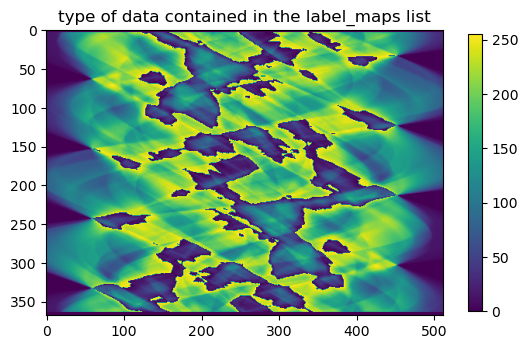

In [11]:
# display of the first data of the label_map
plt.figure()
plt.imshow(label_maps[0])
plt.title("type of data contained in the label_maps list")
plt.colorbar(shrink=0.75)

## 3. Creation of 200 grey-scale sinograms to train the model

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
1/1 [==============================] - 0s 63ms/step


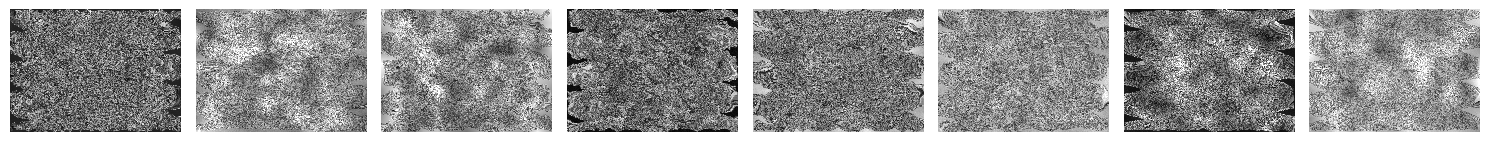

In [12]:
# Image generation. For accurate registration, the landscape of generated warps
# and image contrasts will need to include the target distribution.
gen_arg = dict(
    in_shape= (368, 512), # shape of the sinogram (must be a multiple of 16)
    in_label_list=np.unique(label_maps),
    warp_std=3,
    warp_res=(8, 16, 32),
)
# We separate the grey-scale images created from the label_maps list into two different lists: 
# one containing the grey-scale images corresponding to the "fixed" images and 
# another containing those corresponding to the "moving" images.
gen_model_1 = ne.models.labels_to_image(**gen_arg, id=1)
gen_model_2 = ne.models.labels_to_image(**gen_arg, id=2)


# Test repeatedly for single input.
# We can see several sinogram contrasts from a given sinogram (here from the first "fixed" grey-scale sinogram).
num_gen = 8
input = np.expand_dims(label_maps[0], axis=(0, -1))
slices = [gen_model_1.predict(input)[0] for _ in range(num_gen)]
ne.plot.slices(slices);

## 4. Creation of the model

In [21]:
# Registration model.
reg_model = vxm.networks.VxmDense(
    inshape = (368, 512), # Shape of the sinogram (must be a multiple of 16).
    int_resolution=2,
    svf_resolution=2,
    nb_unet_features=([512]*4, [368]*8),
    reg_field='warp',
)

# Model for optimisation.
ima_1, map_1 = gen_model_1.outputs
ima_2, map_2 = gen_model_2.outputs

_, warp = reg_model((ima_1, ima_2))
pred = vxm.layers.SpatialTransformer(fill_value=0)((map_1, warp))

inputs = gen_model_1.inputs + gen_model_2.inputs
out = (map_2, pred)
model = tf.keras.Model(inputs, out)
# The inputs in a Keras model are used to define the placeholders or containers for the input data that will 
# be fed into the model during training or inference. 
# They represent the expected shape and type of the input data.

# Initialisation of the layers
for layer in model.layers:
    if isinstance(layer, Dense):
        layer.kernel_initializer = tf.initializers.GlorotUniform(seed=1)
        if layer.use_bias:
            layer.bias_initializer = tf.initializers.GlorotUniform(seed=1)
    
# Compilation.
model.add_loss(vxm.losses.Dice().loss(*out) + tf.repeat(1., tf.shape(pred)[0]))
model.add_loss(vxm.losses.Grad('l2', loss_mult=1).loss(None, warp))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

## 5. Train SynthMorph over few epochs

In [22]:
# Train model for a few epochs. 
# Re-running the cell will continue training.

gen = vxm.generators.synthmorph(
    label_maps,
    batch_size=1, # Number of samples per gradient update.
    same_subj=True,
    flip=True,
)

hist = model.fit(
    gen,
    initial_epoch=0,
    epochs=10,
    steps_per_epoch=100,
    verbose=1, # Visualise the progress bar.
)

Epoch 1/10
100/100 [==============================] - 998s 10s/step - loss: 50250140090368.0000
Epoch 2/10
 58/100 [================>.............] - ETA: 6:50 - loss: 26450813790453760.0000

InvalidArgumentError: Graph execution error:

Detected at node 'model_7/vxm_dense/vxm_dense_flow_int/map/while/GatherV2' defined at (most recent call last):
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_23007/2776038216.py", line 10, in <module>
      hist = model.fit(
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/keras/engine/training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/voxelmorph/tf/layers.py", line 252, in call
      # map transform across batch
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/voxelmorph/tf/layers.py", line 270, in _single_int
      odeint_fn=self.odeint_fn)
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/voxelmorph/tf/utils/utils.py", line 372, in integrate_vec
      if method in ['ss', 'scaling_and_squaring']:
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/voxelmorph/tf/utils/utils.py", line 376, in integrate_vec
      if time_dep:
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/voxelmorph/tf/utils/utils.py", line 388, in integrate_vec
      for _ in range(nb_steps):
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/voxelmorph/tf/utils/utils.py", line 389, in integrate_vec
      vec += transform(vec, vec)
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/voxelmorph/tf/utils/utils.py", line 165, in transform
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/neurite/tf/utils/utils.py", line 137, in interpn
      if interp_method == 'linear':
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/neurite/tf/utils/utils.py", line 162, in interpn
      for c in cube_pts:
    File "/home/mamo/anaconda3/envs/cil/lib/python3.10/site-packages/neurite/tf/utils/utils.py", line 178, in interpn
      vol_val = tf.gather(vol_reshape, idx)
Node: 'model_7/vxm_dense/vxm_dense_flow_int/map/while/GatherV2'
indices[175,200] = -2147436800 is not in [0, 47104)
	 [[{{node model_7/vxm_dense/vxm_dense_flow_int/map/while/GatherV2}}]] [Op:__inference_train_function_450236]

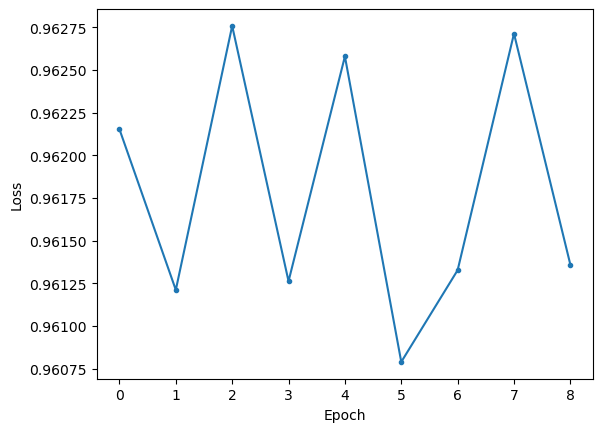

In [18]:
# Visualise loss.
plt.plot(hist.epoch, hist.history['loss'], '.-');
plt.xlabel('Epoch');
plt.ylabel('Loss');

In [10]:
hist.history['loss']

[0.9628521800041199,
 0.961792528629303,
 0.963021457195282,
 0.9610015153884888,
 0.9614642858505249,
 0.9627557992935181,
 0.9620169997215271,
 0.9614868760108948,
 0.9618735313415527,
 0.961051881313324,
 0.9623484015464783,
 0.9622809886932373,
 0.9629284739494324,
 0.962475597858429,
 0.9620335102081299,
 872.9210815429688,
 12517197824.0,
 3115648256.0,
 638534464.0,
 286465312.0,
 154963904.0,
 287830112.0,
 187515520.0,
 117911344.0,
 81034224.0,
 58017676.0,
 43142916.0,
 35132880.0,
 29004674.0,
 22868656.0]